# TP4
## Grupo 15

Carlos Eduardo Da Silva Machado A96936

Gonçalo Manuel Maia de Sousa A97485

## Exercício 4.1

### Descrição do Problema

Pretende-se construir um autómato híbrido que descreva o sistema de travagem ABS ("Anti-Lock Breaking System") e que  possa ser usado para verificar as suas propriedades dinâmicas.

    
1. A componente discreta do autómato contém os modos:  `Start`,  `Free`,  `Stopping`, `Blocked`, e `Stopped`. No modo `Free`  não existe qualquer força de travagem; no modo `Stopping` aplica-se a força de travagem alta; no modo `Blocked` as rodas estão bloqueadas em relação ao corpo mas o veículo  desloca-se; no modo `Stopped` o veículo está imobilizado.
2. A componente contínua  do autómato usa variáveis contínuas $\,V,v\,$ para descrever a  `velocidade do corpo`  do veículo em relação ao solo e a `velocidade linear das rodas` também em relação ao solo. 
        Assume-se que o sistema de travagem exerce uma força de atrito  nos travões proporcional à diferença das duas velocidades.
3. Os "switchs" devem ser definidos de modo a que o sistema tenha um comportamento desejável, isto é, imobilize-se depressa e não “derrape” muito.
4. Além disso, é necessário evitar que o sistema tenha "trajetórias de Zenão". Isto é, sequências  infinitas de transições  entre dois modos em intervalos de tempo que tendem para zero mas nunca alcançam zero.


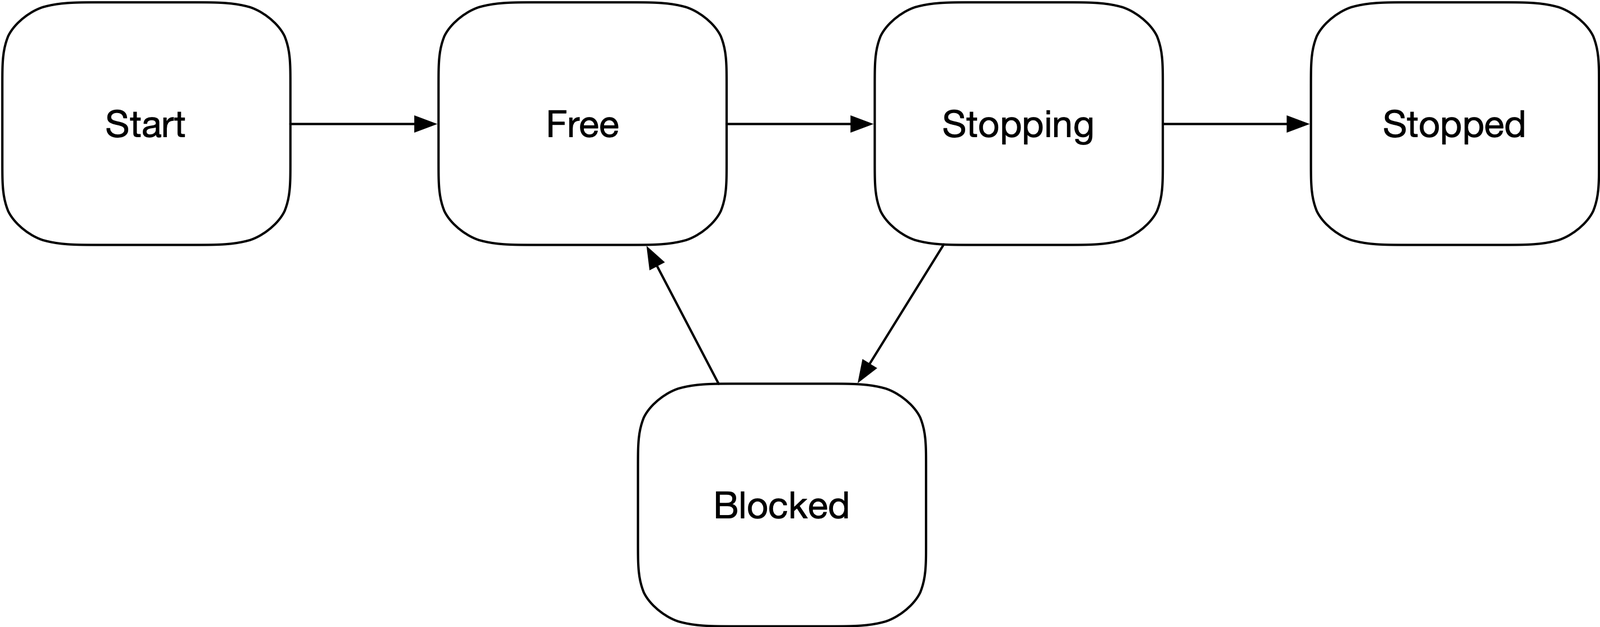
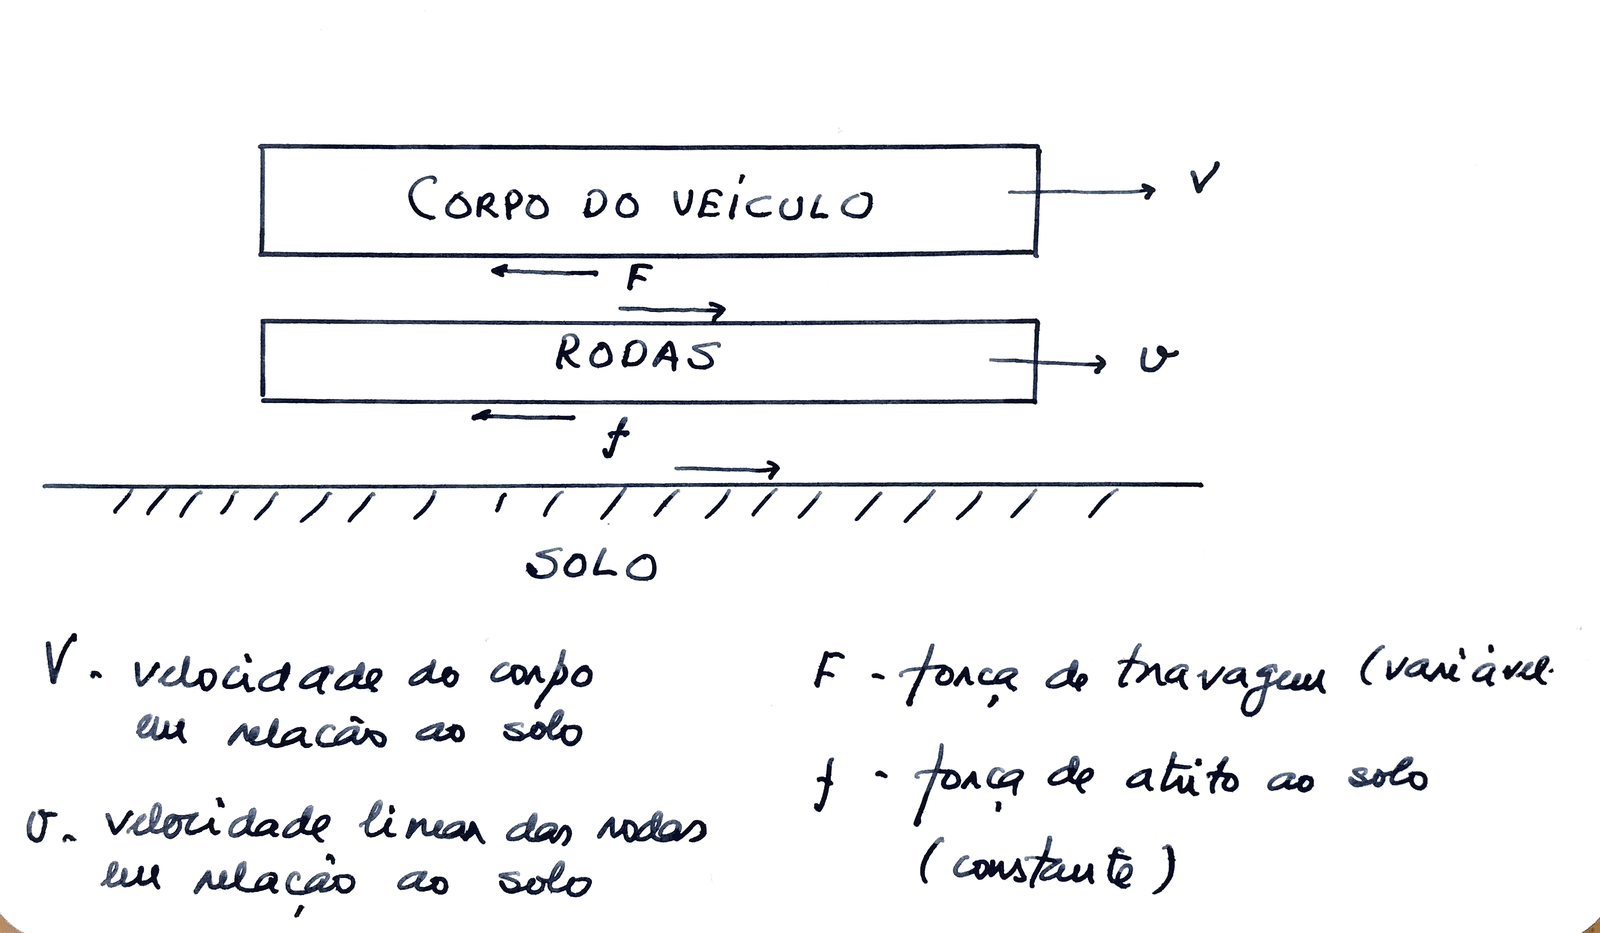

### Abordagem do Problema

Caracterização das contantes e variáveis:
1. Componentes Contínuas:
- velocidade linear das rodas
- velocidade do corpo (veículo)
- tempo
- timer (no nosso caso não é um contador literal)

2. Componentes Discretas:
- Modo

3. Constantes:
- força de atrito do solo no modo block (baixa) e força de atrito nos restantes modos (alta)
- constante de proporcionalidade no modo stopping (alta) e nos restantes (baixa)
- velocidade inicial
- peso
- dif (Valor que utilizamos para verificar que as velocidades V e v estão próximas)
- Tau (Tempo máximo que controla o tempo permanecido nos modos Free e Blocked)
- delta (Pequena porção adicionada ao tempo de modo a evitar as trajetórias de Zenão)


Eventos:
- Start -> Inicio
- Free -> A força de travagem não é exercida sobre o veículo
- Stopping -> É aplicada uma força de travagem alta sobre o veículo
- Blocked -> As rodas estão travadas, porém o veículo continua a mover-se
- Stopped -> O veículo pára

Jumps:
- Start -> Free (Inicia para um movimento livre)
- Free -> Stopping (O veículo começa a travar)
- Stopping -> Blocked (O veículo começa a derrapar)
- Blocked -> Free (O veículo deixa de derrapar)
- Stopping -> Stopped (O veículo pára)

Decisão dos Jumps:

Os jumps ou switches caracterizados pelas transições untimed, forma decididos de forma a obter o comportamento desejável e cumprir com o algumas implicações do enunciado.

1. No jump do start para o free, as variáveis do solver são mantidas à exceção do modo que passa a ser Free.
2. O jump free -> stopping acontece quando o timer do free chegada ao limite Tau através de um "timer", que no nosso caso, em python, o "timer" será uma espécie de "threshold" (limite), a atribuição dessa marca é feita em jumps especificos que envolvem como estado destino tanto o free quanto o blocked, portanto, neste jump em específico o que procuramos é comparar o tempo atual ao do limite e se for maior, então o jump é possível.
3. Stopping -> Blocked, como o destino é o blocked marcamos um novo timer como a soma do tempo atual mais um Tau (constante), obtendo o tempo máximo que o controlo permanece. Além disso, um fator importante para passarmos do stopping para o blocked, é velocidade do corpo do veículo ser próxima da velocidade das rodas, essa próximidade é dada por outra constante com o nome de dif, assim comparamos a diferença entre as duas velocidade e se a mesma for menor que a constante, então o jump é válido.
4. Blocked -> Free, semelhante ao jump free -> stopping, acontece quando o limite atingido e como o destino é free, calculamos o próximo limite.
5. Stopping -> Stopped, acontece quando o veículo praticamente pára, isto, é as velocidades são zero ou muito próximas, utilizamos a constante diff para fazer essa verificação.

## Código Python

Instalação da biblioteca pygraphviz:
- conda install -c conda-forge pygraphviz

Instalação da biblioteca matplotlib:
- conda install -c conda-forge matplotlib

Instalação da biblioteca IPython:
- conda update conda
- conda update ipython

In [1]:
from pysmt.shortcuts import *
from pysmt.typing import *
import matplotlib.pyplot as matplot

Programa que gera o autómato híbrido que descreve o sistema de travagem ABS:

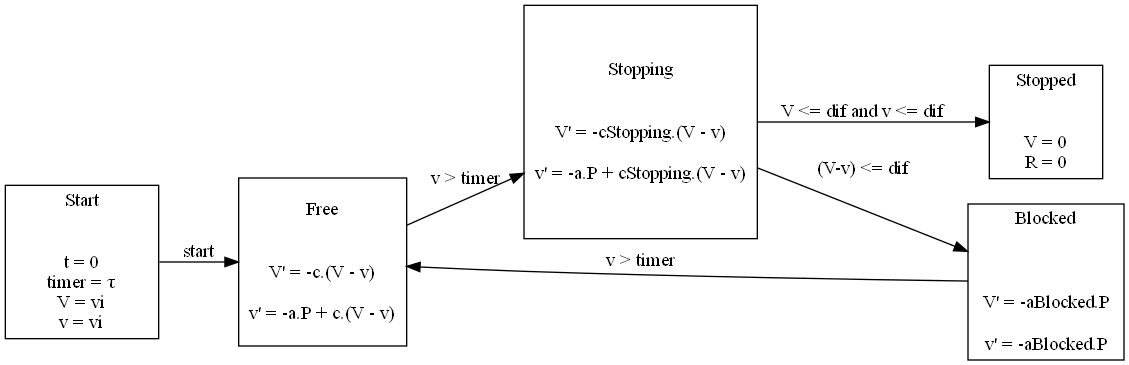

In [2]:
import pygraphviz as pgraph
from IPython.display import Image
AutomatoHibrido = """digraph{
    rankdir=LR;
    Start [shape=square, label="Start\n\n\nt = 0\ntimer = τ\nV = vi\nv = vi"];
    Free [shape = square, label="Free\n\n\nV' = -c.(V - v)\n\nv' = -a.P + c.(V - v)"];
    Stopping [shape = square, label="Stopping\n\n\nV' = -cStopping.(V - v)\n\nv' = -a.P + cStopping.(V - v)"];
    Blocked [shape = square, label="Blocked\n\n\n\nV' = -aBlocked.P\n\nv' = -aBlocked.P"];
    Stopped [shape = square, label="Stopped\n\n\nV = 0\nR = 0"];
    
    Start -> Free[label="start"];
    Free -> Stopping [label="v > timer"];
    Stopping -> Blocked[label="(V-v) <= dif"];
    Stopping -> Stopped[label="V <= dif and v <= dif"];
    Blocked -> Free [label="v > timer"];
}"""

Image(pgraph.AGraph(AutomatoHibrido).draw(format='png', prog='dot'))

Definição das constantes e dos valores dos modos:

In [3]:
Start = Int(-1)
Free = Int(0)
Stopping = Int(1)
Blocked = Int(2)
Stopped = Int(3)

V0 = 20
aBlocked = 0.001
a = 0.01
cStopping = 8
c = 0.5
Tau = 0.3
P = 1500
dif = 0.7 # intervalo entre velocidade do corpo e das rodas
delta = 0.1 # intervalo entre os tempos

Função que simula a evolução das constantes de acordo com as equações diferenciais.

In [4]:
def simulation(a, aBlocked, c, cStopping, dt, dif, P, tau, time, v0):
    V = v0
    v = v0
    t = 0
    V_ = [V]
    v_ = [v]
    T = [t]
    timer = 0
    m = Free
    
    while(t<time and (V>0 or v>0)):
        
        if m == Stopping and (V - v < dif )  :
            m = Blocked
        
        elif timer >= tau and m == Blocked:
            m = Free
            timer = 0
        
        elif timer >= tau and m == Free:
            m = Stopping
            timer = 0 
        
        if m == Free:
            V, v = V + (-c*(V-v))*dt, v + (-a*P + c*(V-v))*dt
        
        elif m == Stopping:
            V, v = V + (-cStopping*(V-v))*dt, v + (-a*P + cStopping*(V-v))*dt
        
        else:
            V, v = V + (-aBlocked*P)*dt, v + (-aBlocked*P)*dt
    
        
        t += dt
        timer += dt
        V_.append(V)
        v_.append(v)
        T.append(t)
        
    
    matplot.plot(T,V_,T,v_)
    matplot.title("Gráfico com a evolução das constantes")
    matplot.xlabel("Tempo (s)")
    matplot.ylabel("Velocidade (m/s)")
    matplot.legend(["Velocidade do corpo", "Velocidade linear das rodas"], loc ="best")
    matplot.grid(True)



Imagem do gráfico gerado:

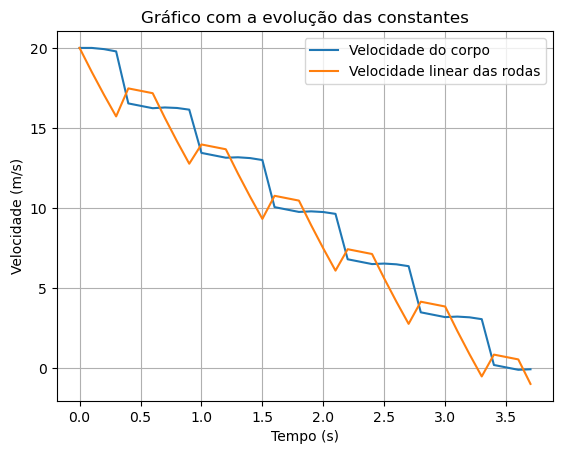

In [5]:
maxtime = 20
timediference = 0.1
simulation(a,aBlocked, c, cStopping, timediference, dif, P, Tau, maxtime, V0)

Função declare cujo objetivo é declarar as variáveis discretas e contínuas.

In [6]:
def declare(i):
    s = {}
    # Discretas
    s['m'] = Symbol('m'+str(i),INT) # Modo
    # Contínuas
    s['t'] = Symbol('t'+str(i),REAL) # Tempo
    s['V'] = Symbol('V'+str(i),REAL) # Velocidade do corpo
    s['v'] = Symbol('v'+str(i),REAL) # velocidade linear das rodas
    s['timer'] = Symbol('timer'+str(i),REAL) # Timer
    return s

Função de inicialização que caracteriza o estado inicial.

In [7]:
def init(s):
    return And(Equals(s['m'], Start),Equals(s['t'],Real(0)), Equals(s['V'], Real(V0)), Equals(s['v'], Real(V0)), Equals(s['timer'],Real(Tau)))

Função de transição que caracteriza as transições entre os estados.

In [8]:
def trans(s,p):
    # untimed
    StartToFree = And(Equals(s['m'],Start), Equals(p['m'],Free),Equals(s['t'],p['t']), Equals(s['V'],p['V']), Equals(s['v'],p['v']),
                         Equals(p['timer'],s['timer']))
    
    FreeToStopping = And(Equals(s['m'],Free), Equals(p['m'],Stopping),Equals(s['t'],p['t']), Equals(s['V'],p['V']), Equals(s['v'],p['v']),
                     Equals(p['timer'],s['timer']), s['t'] > s['timer'])
    
    StoppingToBlocked = And(Equals(s['m'],Stopping), Equals(p['m'],Blocked),Equals(s['t'],p['t']), Equals(s['V'],p['V']), Equals(s['v'],p['v']),
                         Equals(p['timer'],s['t']+Real(Tau)), s['V']-s['v']<=Real(dif))
    
    BlockedToFree = And(Equals(s['m'],Blocked), Equals(p['m'],Free),Equals(s['t'],p['t']), Equals(s['V'],p['V']), Equals(s['v'],p['v']),
                     Equals(p['timer'],s['t'] + Real(Tau)), s['t'] > s['timer'])
    
    StoppingToStopped = And(Equals(s['m'],Stopping), Equals(p['m'],Stopped),Equals(s['t'],p['t']), Equals(s['V'],p['V']), Equals(s['v'],p['v']),
                     Equals(p['timer'],s['timer']), s['v'] <= Real(dif), s['V'] <= Real(dif))

    # timed
    
    FreeFree = And(Equals(s['m'],Free),Equals(p['m'],Free),
                  s['t'] <= s['timer'],
                  Equals(p['t'],s['t'] + Real(delta)),
                  s['v']>=0,p['v']>=0,s['V']>=0,p['v']>=0,
                  Equals(p['timer'], s['timer']),
                  Equals(p['v'] - s['v'], (Real(-1) * Real(a) * Real(P) + (Real(c) * (s['V'] - s['v']))) * (p['t'] - s['t'])),
                  Equals(p['V'] - s['V'], Real(-1) * (Real(c) * (s['V'] - s['v'])) * (p['t'] - s['t']))
                  )
    
    StoppingStopping = And(Equals(s['m'],Stopping),Equals(p['m'],Stopping),
                  Equals(p['t'],s['t']+Real(delta)),
                  s['v']>=0,p['v']>=0,s['V']>=0,p['v']>=0,p['v']>=p['V'],
                  Equals(p['timer'], s['timer']),
                  Equals(p['v'] - s['v'], (Real(-1) * Real(a) * Real(P) + (Real(cStopping) * (s['V'] - s['v']))) * (p['t'] - s['t'])),
                  Equals(p['V'] - s['V'], Real(-1) * (Real(cStopping) * (s['V'] - s['v'])) * (p['t'] - s['t']))
                  )
    
    BlockedBlocked = And(Equals(s['m'],Blocked),Equals(p['m'],Blocked),
                  s['t'] <= s['timer'],
                  Equals(p['t'],s['t']+Real(delta)),
                  s['v']>=0,p['v']>=0,s['V']>=0,p['v']>=0,
                  Equals(p['timer'], s['timer']),
                  Equals(p['V']-s['V'], (Real(-1) * Real(aBlocked) * Real(P)) * (p['t'] - s['t'])),
                  Equals(p['v']-s['v'], (Real(-1) * Real(aBlocked) * Real(P)) * (p['t'] - s['t']))
                  )
    
    StoppedStopped = And(Equals(s['m'],Stopped),Equals(p['m'],Stopped),
                  Equals(p['t'],s['t']+Real(delta)),
                  s['v']>=0,p['v']>=0,s['V']>=0,p['v']>=0,
                  s['v']>=p['v'], s['V']>=p['V'],
                  Equals(p['timer'], s['timer']),
                  Equals(p['v'],Real(0)), Equals(p['V'],Real(0))
                  )
    
    return Or(StartToFree, FreeToStopping, StoppingToBlocked, BlockedToFree, StoppingToStopped, FreeFree, StoppingStopping, BlockedBlocked, StoppedStopped)

Segunda Versão da função de transição onde tentamos reduzir os erros de verificação, reduzindo a granularidade da discretização subdividindo os modos free e Blocked em submodos. Esta ideia segue de uma sugestão da ficha 12, onde cada modo de um termostato poderia ser sub-dividido em 4 sub-modos.
No nosso caso, como sabemos que o veículo perde velocidade, a velocidade inicial é a maior velocidade que o veículo atingiu então conseguimos limitar superiormente, ora, como também sabemos que o veículo irá parar, temos igualmente um limite inferior, portanto, basta subdividir em todas as velocidades, de 0 até V0, de 1 em 1.

Além disso, em vez de avançar com o tempo de v+delta em v+delta, tentamos utilizar intervalos, ou seja, o tempo asseguir tem de ser o tempo atual mais esse delta.

In [9]:
def trans2(s,p):
    # untimed
    
    StartToFree = And(Equals(s['m'], Start),
                      Equals(p['m'], Free),
                      Equals(p['timer'],Real(Tau)),
                      Equals(p['V'], s['V']),
                      Equals(p['v'], s['v']),
                      Equals(p['t'], s['t']))
    
    FreeToStopping = And(Equals(s['m'], Free),
                         Equals(p['m'], Stopping),
                         Equals(p['V'], s['V']),
                         Equals(p['v'], s['v']),
                         Equals(p['t'],s['t']),
                         p['t'] >= s['timer'],
                         Equals(p['timer'],s['timer']))
    
    StoppingToBlocked = And(Equals(s['m'], Stopping),
                            Equals(p['m'], Blocked),
                            s['V']-s['v'] <= Real(dif),
                            Equals(p['V'], s['V']),
                            Equals(p['v'], s['v']),
                            Equals(p['t'], s['t']),
                            Equals(p['timer'],s['t'] + Real(Tau)))
    
    BlockedToFree = And(Equals(s['m'], Blocked),
                        Equals(p['m'], Free),
                        Equals(p['V'], s['V']),
                        Equals(p['v'], s['v']),
                        p['t'] >= s['timer'],
                        Equals(p['timer'],s['t'] + Real(Tau)),
                        Equals(p['t'], s['t']))
    
    StoppingToStopped = And(Equals(s['m'], Stopping),
                            Equals(p['m'], Stopped),
                            Equals(p['V'], s['V']),
                            Equals(p['v'], s['v']),
                            Equals(p['t'], s['t']),
                            p['V'] <= Real(dif),
                            p['v'] <= Real(dif),
                            Equals(p['timer'],s['timer']))
    
    # timed
    
    FreeFree = Or([And(Equals(s['m'], Free),
                   Equals(p['m'], Free),
                   s['V'] >= 0, p['V'] >= 0, s['v'] >= 0, p['v'] >= 0,
                   s['V']-s['v']<Real(i)+Real(dif), s['V']-s['v']>=Real(i)-Real(dif),
                   Equals(p['V']-s['V'], -(Real(c) * i) * (p['t'] - s['t'])),
                   Equals(p['v']-s['v'], (-(Real(a) * Real(P)) + (Real(c) * i)) * (p['t'] - s['t'])), 
                   p['t'] > s['t'] + Real(delta),
                   s['t'] < s['timer'],
                   Equals(p['timer'],s['timer'])) for i in range(0,V0+1)])
    
    StoppingStopping = Or([And(Equals(s['m'], Stopping),
                       Equals(p['m'], Stopping),
                       s['V'] >= 0, p['V'] >= 0, s['v'] >= 0, p['v'] >= 0,
                       s['V']-s['v']<Real(i)+Real(dif), s['V']-s['v']>=Real(i)-Real(dif),
                       Equals(p['V']-s['V'], -(Real(cStopping) * i) * (p['t'] - s['t'])),
                       Equals(p['v']-s['v'], (-(Real(a) * Real(P)) + (Real(cStopping) * i)) * (p['t'] - s['t'])),
                       p['t'] > s['t'] + Real(delta),
                       Equals(p['timer'],s['timer'])) for i in range(0,V0+1)])
    
    BlockedBlocked = And(Equals(s['m'], Blocked),
                         Equals(p['m'], Blocked),
                         Equals(p['V'],s['v']),
                         s['V'] >= 0, p['V'] >= 0, s['v'] >= 0, p['v'] >= 0,
                         Equals(p['v']-s['v'], (-Real(aBlocked) * Real(P)) * (p['t'] - s['t'])),
                         p['t'] > s['t'] + Real(delta),
                         s['t'] < s['timer'],
                         Equals(p['timer'],s['timer']))
    
    StoppedStopped = And(Equals(s['m'],Stopped),Equals(p['m'],Stopped),
                  p['t'] > s['t']+Real(delta),
                  s['v']>=0,p['v']>=0,s['V']>=0,p['v']>=0,
                  Equals(p['timer'], s['timer']),
                  Equals(p['v'],Real(0)), Equals(p['V'],Real(0))
                  )

    return Or(StartToFree, FreeToStopping, StoppingToBlocked, BlockedToFree, StoppingToStopped, FreeFree, StoppingStopping, BlockedBlocked, StoppedStopped)

Função de geração do traço, adapatada das aulas práticas.

In [11]:
def gera_traco(declare,init,trans,k):

    with Solver(name="z3") as s:
    
        # completar
    
        # cria k copias do estado
        trace = [declare(i) for i in range(k)]
    
        # criar o traço
        s.add_assertion(init(trace[0]))
        for i in range(k-1):
            s.add_assertion(trans(trace[i], trace[i+1]))
        
        if s.solve():
            for i in range(k):
                print()
                print("Modo:",i)
                m = s.get_py_value(trace[i]['m'])
                if m==1:
                    print("Stopping")
                elif m==2:
                    print("Blocked")
                    print("timer =", float(s.get_py_value(trace[i]['timer'])))
                elif m==0:
                    print("Free")
                    print("timer =", float(s.get_py_value(trace[i]['timer'])))
                elif m==3:
                    print("Stopped")
                else:
                    print("Start")
                    
                print("t =", round(float(s.get_py_value(trace[i]['t'])),6))
                print("V =", float(s.get_py_value(trace[i]['V'])))
                print("v =", float(s.get_py_value(trace[i]['v'])))
        else:
            print("Solver cannot solve")

In [21]:
gera_traco(declare,init,trans2,20)


Modo: 0
Start
t = 0.0
V = 20.0
v = 20.0

Modo: 1
Free
timer = 0.3
t = 0.0
V = 20.0
v = 20.0

Modo: 2
Free
timer = 0.3
t = 0.3
V = 20.0
v = 15.5

Modo: 3
Stopping
t = 0.3
V = 20.0
v = 15.5

Modo: 4
Stopping
t = 0.440013
V = 15.51958762886598
v = 17.880219072164948

Modo: 5
Blocked
timer = 0.7400128865979381
t = 0.440013
V = 15.51958762886598
v = 17.880219072164948

Modo: 6
Blocked
timer = 0.7400128865979381
t = 0.559601
V = 17.880219072164948
v = 17.70083762886598

Modo: 7
Blocked
timer = 0.7400128865979381
t = 0.679188
V = 17.70083762886598
v = 17.52145618556701

Modo: 8
Blocked
timer = 0.7400128865979381
t = 7.545855
V = 17.52145618556701
v = 7.2214561855670105

Modo: 9
Free
timer = 7.845854810996563
t = 7.545855
V = 17.52145618556701
v = 7.2214561855670105

Modo: 10
Free
timer = 7.845854810996563
t = 7.726267
V = 16.529188144329897
v = 5.5075386597938145

Modo: 11
Free
timer = 7.845854810996563
t = 7.845855
V = 15.87145618556701
v = 4.37145618556701

Modo: 12
Stopping
t = 7.845855
V

### Provar propriedades

Função *bmc_always* alterada para verificar a propriedade ii)

In [13]:
def bmc_always(declare,init,trans,prop,K):
    for k in range(1,K+1):
        with Solver(name="z3") as s:
            
            # completar
            trace = [declare(i) for i in range(k)]
            
            invariante = []
            s.add_assertion(init(trace[0]))
            for i in range(k-1):
                s.add_assertion(trans(trace[i], trace[i+1]))
                invariante.append(Not(prop(trace[i], trace[i+1])))
            s.add_assertion(Or(invariante)) 
            #s.add_assertion(Not(prop(trace[k-1])))
            if s.solve():
                for i in range(k):
                    print()
                    print("State:",i)
                    m = s.get_py_value(trace[i]['m'])
                    if m==1:
                        print("Stopping")
                    elif m==2:
                        print("Blocked")
                        print("timer =", float(s.get_py_value(trace[i]['timer'])))
                    elif m==0:
                        print("Free")
                        print("timer =", float(s.get_py_value(trace[i]['timer'])))
                    elif m==3:
                        print("Stopped")
                    else:
                        print("Start")
                    
                    print("t =", float(s.get_py_value(trace[i]['t'])))
                    print("V =", float(s.get_py_value(trace[i]['V'])))
                    print("v =", float(s.get_py_value(trace[i]['v'])))
                return
                
    print("A propriedade é válida para traços de tamanho até " + str(k))

Função *bmc_eventually* alterada para verificar a propriedade i)

In [14]:
def bmc_eventually(declare,init,trans,prop,tempo,bound):
    for k in range(1,bound+1):
         with Solver(name="z3") as s:
            # completar
            trace = [declare(i) for i in range(k)]
    
            s.add_assertion(init(trace[0]))
            for i in range(k-1):
                s.add_assertion(trans(trace[i], trace[i+1]))
            
            for i in range(k):
                s.add_assertion(Not(prop(trace[i],tempo)))
            
            s.add_assertion(Or(trans(trace[k-1],trace[i]) for i in range(k)))
            
            if s.solve():
                for i in range(k):
                    print()
                    print("State:",i)
                    m = s.get_py_value(trace[i]['m'])
                    if m==1:
                        print("Stopping")
                    elif m==2:
                        print("Blocked")
                        print("timer =", float(s.get_py_value(trace[i]['timer'])))
                    elif m==0:
                        print("Free")
                        print("timer =", float(s.get_py_value(trace[i]['timer'])))
                    elif m==3:
                        print("Stopped")
                    else:
                        print("Start")
                    
                    print("t =", float(s.get_py_value(trace[i]['t'])))
                    print("V =", float(s.get_py_value(trace[i]['V'])))
                    print("v =", float(s.get_py_value(trace[i]['v'])))
                return
            
    print("A propriedade é válida para traços de tamanho até " + str(k))

Propriedade 1: "o veículo imobiliza-se completamente em menos de $t$ segundos" 
$$
t >= t2 \implies m = Stopped \lor ( v \leq 0 \land V \leq 0 )
$$

In [15]:
def propriedade1(s,t2):
    return Implies(s['t'] >= t2, Or(Equals(s['m'],Stopped),And(s['v'] <= 0, s['V'] <= 0)))

In [16]:
tempo = 5
bmc_eventually(declare,init,trans,propriedade1,tempo,20)

A propriedade é válida para traços de tamanho até 20


Propriedade 2: "a velocidade $V$ diminui sempre com o tempo"
$$
t < t' \iff V > V'
$$

A propriedade falha estranhamente na passagem do primeiro estado para o segundo.

In [17]:
def propriedade2(s,p):
    return Iff(s['t'] < p['t'],s['V'] > p['V'])

In [18]:
bmc_always(declare, init, trans, propriedade2, 20)


State: 0
Start
t = 0.0
V = 20.0
v = 20.0

State: 1
Free
timer = 0.3
t = 0.0
V = 20.0
v = 20.0

State: 2
Free
timer = 0.3
t = 0.1
V = 20.0
v = 18.5
